Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Taxi"

In [1]:
import numpy as np
import random
import json
from taxi_env_extended import TaxiEnvExtended

In [91]:
%pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB 991.0 kB/s eta 0:00:12
   ---------------------------------------- 0.1/11.6 MB 1.5 MB/s eta 0:00:08
   ---------------------------------------- 0.1/11.6 MB 1.5 MB/s eta 0:00:08
   - -------------------------------------- 0.3/11.6 MB 2.0 MB/s eta 0:00:06
   - -------------------------------------- 0.5/11.6 MB 2.8 MB/s eta 0:00:04
   ---- ----------------------------------- 1.4/11.6 MB 6.1 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/11.6 MB 8.1 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/11.6 MB 8.1 MB/s eta 0:00:02
   --------- ------------------------------ 2.8/11.6 MB 8.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.2/11.6 MB 9.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.8/11.6 MB 9.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.1/11.6 MB 9.8 MB/s eta 0:00:01
   -

In [2]:
env = TaxiEnvExtended()

Obtener la cantidad de estados y acciones

In [3]:
actions = env.action_space.n
states = env.observation_space.n

Inicialización de la tabla Q

In [4]:
Q = np.zeros((states, actions))
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Obtención de la acción a partir de la tabla Q

In [5]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

Epsilon-Greedy Policy

In [6]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    # exploit
    else:
        action = np.argmax(Q[state])
        
    return action

In [7]:
# Probar policy

def testPolicy(Q, env):
    obs, _ = env.reset()
    done = False
    totalReward = 0
    while not done:
        env.render()
        state = obs
        action = optimal_policy(state, Q)
        obs, reward, done, _, _ = env.step(action)
        totalReward += reward
    env.render()
    wandb.log({'test_reward_by_episode': totalReward, 'episode': "trial"})
    return totalReward


In [98]:
# Chequeo de la política óptima
# Total reward / cantidad de episodios. Reward promedio de policy.
#Wandb: Sweeps

# Testear la política 100 veces

import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc
def getAverageTestingReward(Q, env):
    rewards = []
    for i in range(100):
        reward = testPolicy(Q, env)
        print(reward)
        rewards.append(reward)
    print(np.mean(rewards))     #Promedio de la recompensa total de cada episodio
    return np.mean(rewards) 


In [99]:
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

def train_policy():
    try:
        with wandb.init() as run:
            config = run.config
            alpha = config.alpha
            gamma = config.gamma
            epsilon = config.epsilon
            epsilon_variability = config.epsilonVariability
            episodes = config.episodes

            env = TaxiEnvExtended()
            Q = np.zeros([env.observation_space.n, env.action_space.n])

            total_rewards = []

            for episode in range(episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                step_count = 0

                while not done:
                    state = obs
                    epsilon = max(epsilon - epsilon_variability * epsilon, 0)  # Decay epsilon
                    action = epsilon_greedy_policy(state, Q, epsilon)
                    obs, reward, done, _, _ = env.step(action)
                    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[obs]) - Q[state, action])
                    total_reward += reward
                    step_count += 1

                total_rewards.append(total_reward)
                wandb.log({'train_reward_by_episode': total_reward, 'episode': episode, 'train_avg_reward': np.mean(total_rewards)})

            test_average_reward = getAverageTestingReward(Q, env)
            wandb.log({'test_avg_reward': test_average_reward})
            # Guardar hiperparámetros y resultados como artefacto
            hyperparameters = {
                'alpha': alpha,
                'gamma': gamma,
                'epsilon': epsilon,
                'epsilonVariability': epsilon_variability,
                'episodes': episodes,
                'train_avg_reward': np.mean(total_rewards),
                'test_avg__reward': test_average_reward
            }
            
            with open('hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f)

            artifact = wandb.Artifact('hyperparameters', type='hyperparameters')
            artifact.add_file('hyperparameters.json')
            run.log_artifact(artifact)


    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        wandb.finish()


In [100]:
import wandb

# Configuración del sweep
sweep_configuration = {
    "method": "random",
    "metric": {"goal": "maximize", "name": 'avg_total_reward'},
    "parameters": {
        "episodes": {"max": 10000, "min": 9999},
        "alpha": {"max": 0.99, "min": 0.5},
        "gamma": {"max": 0.8, "min": 0.3},
        "epsilon": {"max": 0.8, "min": 0.1},
        "epsilonVariability": {"max": 0.5, "min": 0.35}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="taxi-sweep")
wandb.agent(sweep_id, function=train_policy)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

Pruebo ciertos hiperparámetros en específico luego de Sweep:

In [8]:


def train_finalPolicy():
    try:
            alpha = 0.8894046109188853
            gamma = 0.5333435999129466
            epsilon = 0.7391381811833376
            epsilon_variability = 0.4889625280062114
            episodes = 10000

            env = TaxiEnvExtended()
            Q = np.zeros([env.observation_space.n, env.action_space.n])

            total_rewards = []

            for episode in range(episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                step_count = 0

                while not done:
                    state = obs
                    epsilon = max(epsilon - epsilon_variability * epsilon, 0)  # Decay epsilon
                    action = epsilon_greedy_policy(state, Q, epsilon)
                    obs, reward, done, _, _ = env.step(action)
                    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[obs]) - Q[state, action])
                    total_reward += reward
                    step_count += 1

                total_rewards.append(total_reward)
                print(f"Episode {episode} - Total reward: {total_reward}, avg_total_reward: {np.mean(total_rewards)}")
            return Q


    except Exception as e:
        print(f"An error occurred: {e}")




In [9]:
Q = train_finalPolicy()

Episode 0 - Total reward: -560, avg_total_reward: -560.0
Episode 1 - Total reward: -497, avg_total_reward: -528.5
Episode 2 - Total reward: -524, avg_total_reward: -527.0
Episode 3 - Total reward: -578, avg_total_reward: -539.75
Episode 4 - Total reward: -560, avg_total_reward: -543.8
Episode 5 - Total reward: -344, avg_total_reward: -510.5
Episode 6 - Total reward: -596, avg_total_reward: -522.7142857142857
Episode 7 - Total reward: -587, avg_total_reward: -530.75
Episode 8 - Total reward: -560, avg_total_reward: -534.0
Episode 9 - Total reward: -317, avg_total_reward: -512.3
Episode 10 - Total reward: -524, avg_total_reward: -513.3636363636364
Episode 11 - Total reward: -380, avg_total_reward: -502.25
Episode 12 - Total reward: -461, avg_total_reward: -499.0769230769231
Episode 13 - Total reward: -533, avg_total_reward: -501.5
Episode 14 - Total reward: -403, avg_total_reward: -494.93333333333334
Episode 15 - Total reward: -308, avg_total_reward: -483.25
Episode 16 - Total reward: -4

Visualización de mejor policy

Moviepy - Building video C:\Users\santi\AppData\Local\Temp\tmpxhvsx07y\simulation.mp4.
Moviepy - Writing video C:\Users\santi\AppData\Local\Temp\tmpxhvsx07y\simulation.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\santi\AppData\Local\Temp\tmpxhvsx07y\simulation.mp4


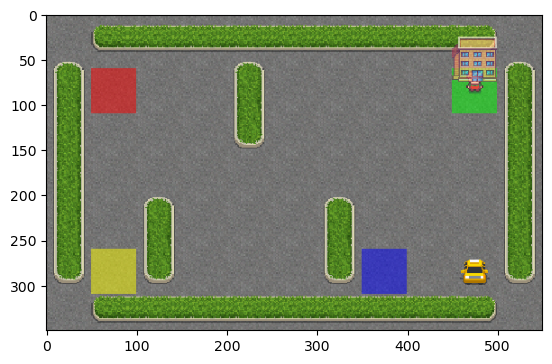

In [15]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import wandb
import moviepy.editor as mpy
import tempfile
import os

# Inicialización del entorno y wandb
obs, _ = env.reset()
done = False
fig, ax = plt.subplots()
img = ax.imshow(env.render(), animated=True)
wandb.init(project="taxi-visualize-predictions", name="simulation")

# Lista para almacenar las imágenes
frames = []
step = 0
actionList = []
while step != 100:
    step = step + 1
    state = obs
    action = optimal_policy(obs, Q)
    print(action)
    actionList.append(action)
    obs, reward, done, _, _ = env.step(action)

    # Actualización de la imagen con el nuevo estado del entorno
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)  # Asegura una transición suave en Jupyter Notebook

    # Guardar la figura actual como una imagen en la lista de frames
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

# Crear un video a partir de las imágenes guardadas
clip = mpy.ImageSequenceClip(frames, fps=4)
with tempfile.TemporaryDirectory() as tmpdirname:
    video_path = os.path.join(tmpdirname, "simulation.mp4")
    clip.write_videofile(video_path)

    # Loguear el video en wandb
    wandb.log({"simulation": wandb.Video(video_path, fps=4, format="mp4")})

# Finalizar sesión en wandb
wandb.finish()


In [28]:
%pip install wandb--0.15.11

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement wandb--0.15.11 (from versions: none)
ERROR: No matching distribution found for wandb--0.15.11
